# Single Cell RNA-Seq analysis with Seurat
*Waldeyr Mendes Cordeiro da Silva; compiled on Mar-2021*

## Case Study

This case study is part of the Chapter "Transcriptome Analysis Throughout RNA-seq" by Brigido et al.

Single-cell RNA-Seq (scRNA-Seq) profiles gene expression of individual cells that can be identified by Unique Molecular Identifiers (UMIs).

Fang Li et al. (2020) have conducted a study using single-cell transcriptome sequencing (scRNA-seq), single-cell BCR sequencing (scBCR-seq), and deep BCR repertoire in order to reveal neutralizing antibody sequences in patients who have recently cleared the virus.
They collected blood samples (Peripheral blood mononuclear cells - PBMCs) from 16 COVID-19 patients and 8 healthy controls to reveal the changes of immune cells caused by SARS-CoV-2 infection. 

This case study uses a single sample of the Fang Li et al. (2020) dataset to demonstrate how to identify distinct types of cells based on their transcripts.
For that we filtered the data to work only with P3 and P10 samples. 
These samples are both from female 59 years old COVID-19 patients with distinct levels of  severity.
* P3 =	59 years old, female, Severe COVID-19
* P10 =	59 years old, female, Moderate COVID-19

Data is available in https://zenodo.org/record/3744141.


Li, F., Luo, M., Zhou, W., Li, J., Jin, X., Xu, Z., ... & Jiang, Q. (2020). Single cell RNA and immune repertoire profiling of COVID-19 patients reveal novel neutralizing antibody. Protein & cell, 1-5.

In [ ]:
if (!requireNamespace("BiocManager", quietly = TRUE))
    install.packages("BiocManager")
BiocManager::install(version = "3.12")

BiocManager::install('ggplot2')
BiocManager::install('ggrepel')
BiocManager::install('limma')
BiocManager::install('calibrate')
BiocManager::install('dplyr')
BiocManager::install('Matrix')
BiocManager::install('Seurat') # It requires R version 4.x

In [85]:
options(warn=-1)

library(limma)
library(calibrate)
library(dplyr)
library(Matrix)
library(Seurat)
library(ggplot2)
library(ggrepel)

packageVersion("limma")
packageVersion("calibrate")
packageVersion("dplyr")
packageVersion("Matrix")
packageVersion("Seurat")
packageVersion("ggplot2")
packageVersion("ggrepel")

[1] ‘3.46.0’

[1] ‘1.7.7’

[1] ‘1.0.5’

[1] ‘1.3.2’

[1] ‘4.0.1’

[1] ‘3.3.3’

[1] ‘0.9.1’

Download and read data from https://zenodo.org/record/3744141

In [86]:
#system("wget https://zenodo.org/record/3744141/files/COVID-19.tar.gz")
#system("tar -xzvf COVID-19.tar.gz")
covid_19_data <- Read10X(data.dir = "COVID-19")
dim(covid_19_data) # dimensions for full data

[1] 33538 96404

Filtering data to work only with P3 and P10 samples. 
* P3 =	59 years old, female, Severe COVID-19
* P10 =	59 years old, female, Moderate COVID-19

In [87]:
p3_and_p10_data <- covid_19_data[, grep(pattern = "P3|P10", colnames(covid_19_data))]
dim(p3_and_p10_data) # dimensions for selected data

[1] 33538 16056

Initialize the Seurat object with the raw (non-normalized data) constrained by the following parameters:
* minimal of two cells with at least 20 expressed genes and at least 2000 features.


In [88]:
covid_p3_p10 <- CreateSeuratObject(
    counts = p3_and_p10_data, 
    project = "COVID-19", 
    min.cells = 2, 
    min.genes = 20, 
    min.features = 2000
)
dim(covid_p3_p10)

[1] 17169  2123

Create a column to identify the patients. It is going to be useful for some plots.

In [89]:
covid_p3_p10[["patient"]] <- sapply(strsplit(colnames(covid_p3_p10),"-"), `[`, 1)
head(covid_p3_p10[[]])

,orig.ident,nCount_RNA,nFeature_RNA,patient
,<fct>,<dbl>,<int>,<chr>
P3-AAACCTGAGTACCGGA,COVID-19,6501,2063,P3
P3-AAACGGGCATCCGGGT,COVID-19,8794,2541,P3
P3-AAAGATGGTATCAGTC,COVID-19,6605,2118,P3
P3-AAAGATGTCGCTTGTC,COVID-19,8523,2391,P3
P3-AAATGCCCACAGATTC,COVID-19,8314,2520,P3
P3-AAATGCCTCACAACGT,COVID-19,10841,3029,P3


Before to start the data processing, let’s flag some information on these data. 
The [[]] operator can add columns to a object metadata. 
In this case, we stash QC stats mitochondrial samples, which are identified starting by "MT-"

In [90]:
covid_p3_p10[["perc_mitochondrial"]] <- PercentageFeatureSet(covid_p3_p10, pattern = "^MT-")
head(covid_p3_p10[[]])

,orig.ident,nCount_RNA,nFeature_RNA,patient,perc_mitochondrial
,<fct>,<dbl>,<int>,<chr>,<dbl>
P3-AAACCTGAGTACCGGA,COVID-19,6501,2063,P3,7.891094
P3-AAACGGGCATCCGGGT,COVID-19,8794,2541,P3,5.992722
P3-AAAGATGGTATCAGTC,COVID-19,6605,2118,P3,4.799394
P3-AAAGATGTCGCTTGTC,COVID-19,8523,2391,P3,4.376393
P3-AAATGCCCACAGATTC,COVID-19,8314,2520,P3,5.436613
P3-AAATGCCTCACAACGT,COVID-19,10841,3029,P3,4.750484


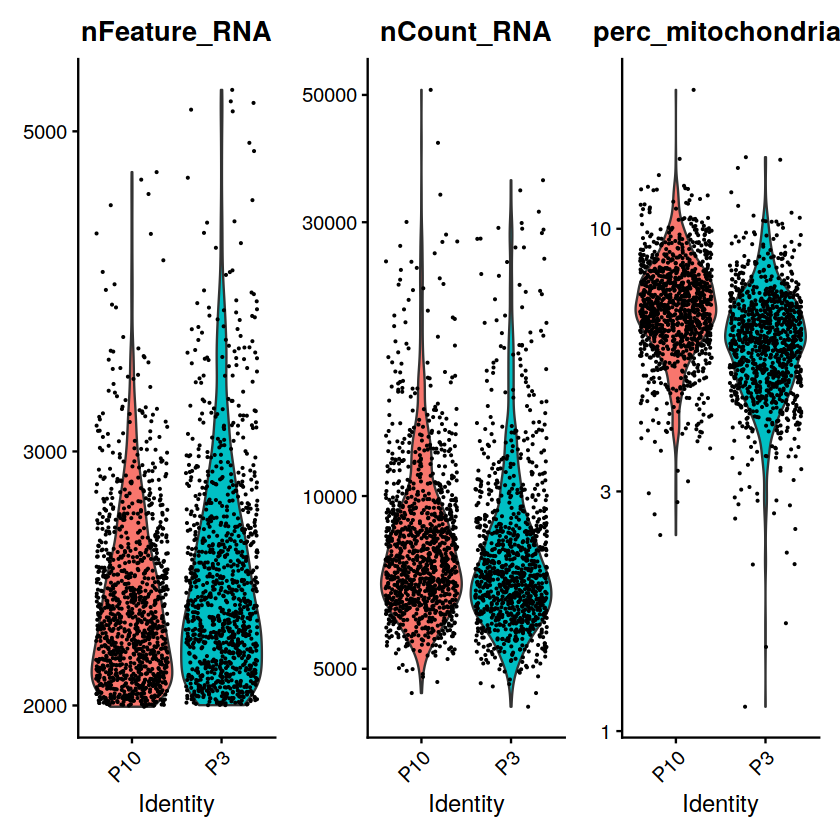

In [91]:
plot_perc_mitochondrial <- VlnPlot(
    covid_p3_p10, 
    features = c("nFeature_RNA", "nCount_RNA", "perc_mitochondrial"), 
    ncol = 3, 
    group.by = "patient",
    log = TRUE
)
plot_perc_mitochondrial

Removing unwanted cells from the dataset. In this case we have applied a filter to keep only samples keeping the number of features at least equal to 2000, but with less than 5% of mitochondrial samples.

In [92]:
covid_p3_p10 <- subset(covid_p3_p10, subset = nFeature_RNA >= 2000 & perc_mitochondrial < 5)
dim(covid_p3_p10[[]])

[1] 746   5

The function LogNormalize() normalizes the feature expression measurements for each cell by the total expression It multiplies this by a scale factor (10,000 by default), and log-transforms the result. 
Normalized values will be stored in covid_p3_p10[["RNA"]]@data.

In [93]:
covid_p3_p10 <- NormalizeData(covid_p3_p10, normalization.method = "LogNormalize", scale.factor = 10000)
dim(covid_p3_p10[[]])

[1] 746   5

We can also generate a FeatureScatter, which is typically used to visualize feature-feature relationships, but can be used for anything calculated by the object, i.e. columns in object metadata, PC scores etc. In this case, it shows read count versus percentage of mitochondrial in a) and read count versus number of features in b)


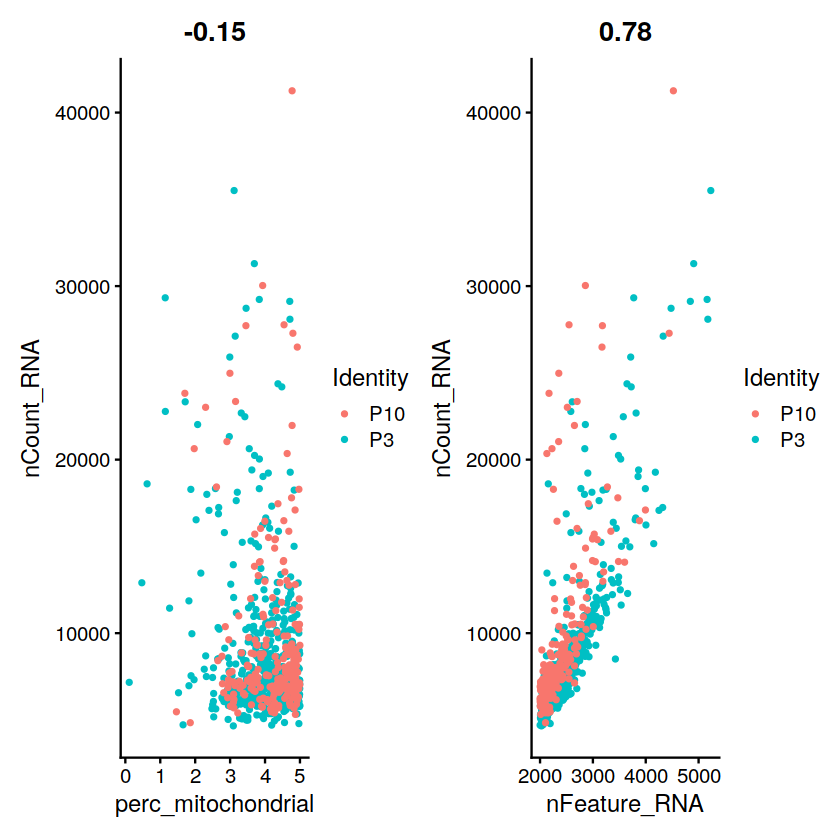

In [94]:
plot_feature_scatter_a <- FeatureScatter(
    covid_p3_p10, feature1 = "perc_mitochondrial", 
    feature2 = "nCount_RNA", 
    group.by = "patient")
plot_feature_scatter_b <- FeatureScatter(
    covid_p3_p10, 
    feature1 = "nFeature_RNA", 
    feature2 = "nCount_RNA", 
    group.by = "patient")
plot_feature_scatter_a + plot_feature_scatter_b

Once normalized, the next step is to identify highly variable features (feature selection)using the method vst which, according to the manual of Seurat, fits a line to the relationship of log (variance) and log (mean) using local polynomial regression (loess). Then, it standardizes the feature values using the observed mean and expected variance (given by the fitted line). The next step is to calculate the feature variance on the standardized values after clipping to a maximum (default is 'auto' which sets this value to the square root of the number of cells)

In [95]:
covid_p3_p10 <- FindVariableFeatures(covid_p3_p10, selection.method = "vst", nfeatures = 2000)
dim(covid_p3_p10[[]])

[1] 746   5

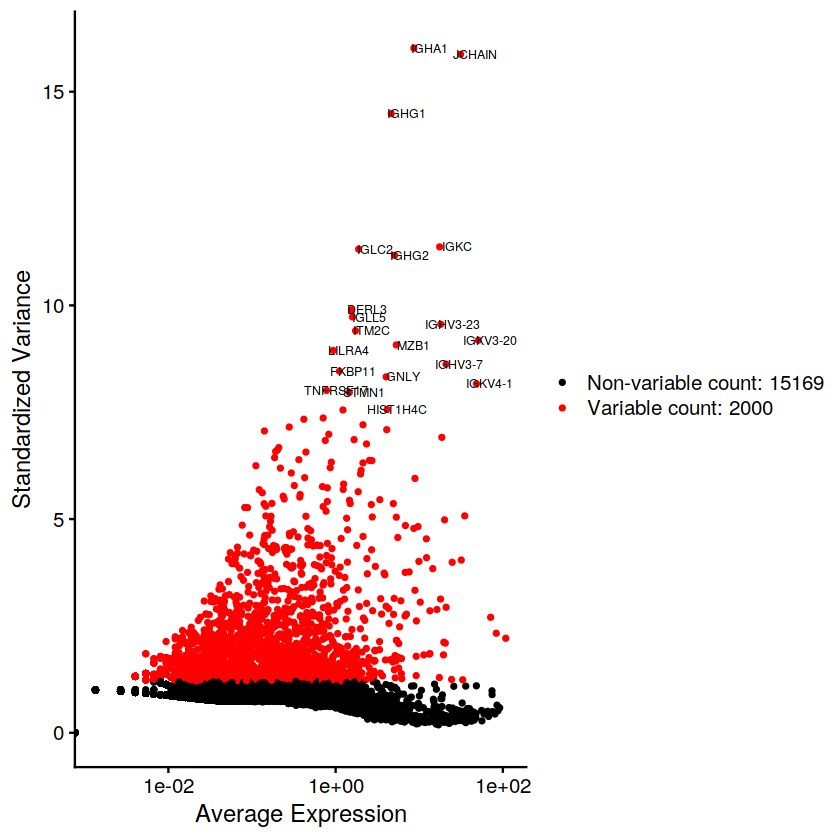

In [96]:
top20 <- head(VariableFeatures(covid_p3_p10), 20)
plot_top20 <- VariableFeaturePlot(covid_p3_p10) 
plot_top20 <- LabelPoints(plot = plot_top20, points = top20, size = 2.5, hjust = .75, vjust = .75) 
plot_top20

Now let’s take a look in the 20 most highly variable genes identified.

In [97]:
top20

[1] "IGHA1"    "JCHAIN"   "IGHG1"    "IGKC"     "IGLC2"    "IGHG2"   
 [7] "DERL3"    "IGLL5"    "IGHV3-23" "ITM2C"    "IGKV3-20" "MZB1"    
[13] "LILRA4"   "IGHV3-7"  "FKBP11"   "GNLY"     "IGKV4-1"  "TNFRSF17"
[19] "STMN1"    "HIST1H4C"

Before to perform the dimensional reduction, it is necessary perform a linear transformation scaling the data. It is a standard pre-processing step prior to apply techniques like PCA. 
* Scaling the data
* Linear dimensional reduction itself

In [98]:
all_genes_covid_p3_p10 <- rownames(covid_p3_p10)
covid_p3_p10 <- ScaleData(covid_p3_p10, features = all_genes_covid_p3_p10)
covid_p3_p10 <- RunPCA(covid_p3_p10, features = VariableFeatures(object = covid_p3_p10))

Centering and scaling data matrix

PC_ 1 
Positive:  PTPRCAP, CENPM, RRM2, MKI67, PTTG1, STMN1, PCLAF, C12orf75, TYMS, LIME1 
	   SEPT1, BIRC5, ZWINT, IL2RG, IL32, TRBC2, TMEM106C, HIST1H4C, MCM2, CD3D 
	   GINS2, LCK, MAD2L1, CLSPN, UBE2C, NPM1, ISG20, CD3E, SIT1, SUB1 
Negative:  CST3, S100A9, S100A8, IFITM3, S100A12, RETN, CFD, CPVL, FOS, DUSP6 
	   TMEM176B, MS4A7, CD36, CSF1R, RNASE2, PLBD1, CD163, AC020656.1, HLA-DRA, LGALS2 
	   CD300E, FCGR2A, TMEM176A, DUSP1, HLA-DRB1, CEBPD, HMOX1, APOBEC3A, GPBAR1, MAFB 
PC_ 2 
Positive:  JCHAIN, MZB1, DERL3, PPIB, ITM2C, SEC61B, HSP90B1, SSR4, IGKC, TNFRSF17 
	   SEC11C, PDIA4, SPCS1, CD74, TXNDC5, SSR3, BLNK, GNG7, SEL1L3, TMED10 
	   IGLL5, ST6GALNAC4, POU2AF1, ERLEC1, IRF4, LMAN1, TMEM258, HERPUD1, EAF2, SLAMF7 
Negative:  CAVIN2, TUBB1, GP9, AC147651.1, TSC22D1, CMTM5, TRIM58, MPIG6B, ABLIM3, TMEM40 
	   PF4, ESAM, MEIS1, TUBA8, PPBP, GATA1, GUCY1B1, AC090409.1, SELP, CLDN5 
	   LGALSL, RAB27B, MMD, DMTN, HIST1H3H, BMP6, LINC02284, SPAR

Now, let’s determine the dimensionality of the dataset. The function JackStraw() determines the statistical significance of PCA scores by randomically permuting a subset of data, and calculates projected PCA scores for these 'random' genes. Following, the ScoreJackStraw()  computes the scores significance by PCs showing a p-value distribution that is strongly skewed to the left compared to the null distribution.

In [99]:
covid_p3_p10 <- JackStraw(covid_p3_p10, num.replicate = 100)
covid_p3_p10 <- ScoreJackStraw(covid_p3_p10, dims = 1:5)

We can now cluster the cells. The function FindNeighbors() computes the k.param nearest neighbors for a given dataset using the k-nearest neighbors algorithm. Then, the function FindClusters() identifies clusters of cells from the SNN graph (result of the k-nearest neighbors algorithm). As higher is the resolution parameter as larger will be the communities. 


In [100]:
covid_p3_p10 <- FindNeighbors(covid_p3_p10, dims = 1:5)
covid_p3_p10 <- FindClusters(covid_p3_p10, resolution = 1)
head(Idents(covid_p3_p10), 5)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 746
Number of edges: 19844

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8009
Number of communities: 10
Elapsed time: 0 seconds


P3-AAAGATGGTATCAGTC P3-AAAGATGTCGCTTGTC P3-AAATGCCTCACAACGT P3-AACACGTGTTTGACTG 
                  0                   1                   1                   1 
P3-AACACGTTCGTGGGAA 
                  0 
Levels: 0 1 2 3 4 5 6 7 8 9

Uniform Manifold Approximation and Projection (UMAP) is a dimensional reduction technique that can be used for visualisation similarly to t-SNE, but also for general non-linear dimension reduction. It is founded on three assumptions about the data: i) the data is uniformly distributed on a Riemannian manifold; ii) the Riemannian metric is locally constant (or can be approximated as such); iii) the manifold is locally connected.

[Caution: It takes some time.]

In [148]:
covid_p3_p10 <- RunUMAP(covid_p3_p10, dims = 1:10)
# It could be alternatively done using tSNE
#covid_p3_p10 <- RunTSNE(object = covid_p3_p10, dims.use = 1:10)

13:27:42 UMAP embedding parameters a = 0.9922 b = 1.112

13:27:42 Read 746 rows and found 10 numeric columns

13:27:42 Using Annoy for neighbor search, n_neighbors = 30

13:27:42 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

13:27:42 Writing NN index file to temp file /tmp/RtmpxWPfSw/file1320c18a9ce5b

13:27:42 Searching Annoy index using 1 thread, search_k = 3000

13:27:42 Annoy recall = 100%

13:27:43 Commencing smooth kNN distance calibration using 1 thread

13:27:43 Initializing from normalized Laplacian + noise

13:27:43 Commencing optimization for 500 epochs, with 25994 positive edges

13:27:44 Optimization finished



 Finally it is possible to plot the clusters of distinct types of cell in the blood sample. Using these parameters, we can find 10 clusters.

In [149]:
head(covid_p3_p10[[]])

,orig.ident,nCount_RNA,nFeature_RNA,patient,perc_mitochondrial,RNA_snn_res.1,seurat_clusters
,<fct>,<dbl>,<int>,<chr>,<dbl>,<fct>,<fct>
P3-AAAGATGGTATCAGTC,COVID-19,6605,2118,P3,4.799394,0,0
P3-AAAGATGTCGCTTGTC,COVID-19,8523,2391,P3,4.376393,1,1
P3-AAATGCCTCACAACGT,COVID-19,10841,3029,P3,4.750484,1,1
P3-AACACGTGTTTGACTG,COVID-19,10012,2772,P3,3.865362,1,1
P3-AACACGTTCGTGGGAA,COVID-19,7600,2258,P3,3.539474,0,0
P3-AACACGTTCTTGCCGT,COVID-19,21327,3385,P3,2.977446,6,6


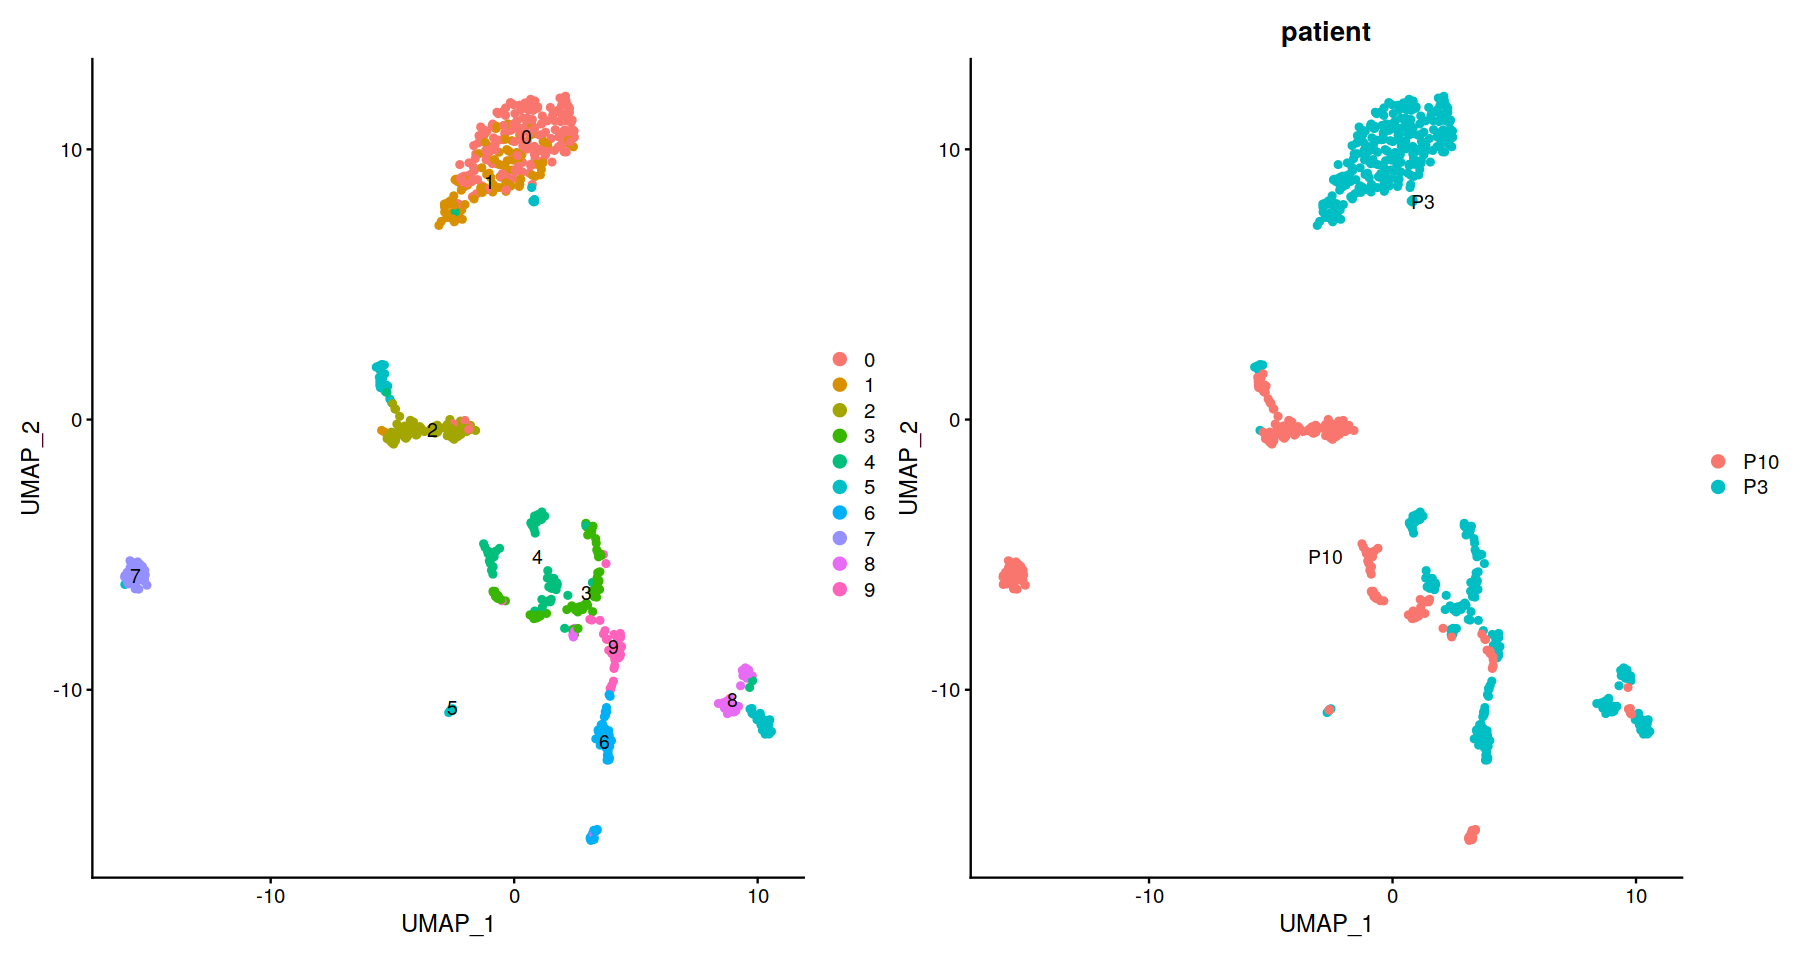

In [150]:
plot_clusters <- DimPlot(covid_p3_p10, label = TRUE, pt.size=1.5, )
plot_patient <- DimPlot(covid_p3_p10, label = TRUE, pt.size=1.5, group.by = "patient")
plot_clusters + plot_patient

Find markers for every cluster compared to all remaining cells, reporting all up and down. \[Caution: It takes some time.\]

The function FindAllMarkers finds all differentially expressed genes for each of the identity classes in a dataset. Some constraints can be used to filter these genes, as *min.pct* that test for genes that are infrequently expressed. 

In [103]:
covid_p3_p10_markers <- FindAllMarkers(object = covid_p3_p10, min.pct = 0.05)
head(covid_p3_p10_markers)

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8

Calculating cluster 9



,p_val,avg_log2FC,pct.1,pct.2,p_val_adj,cluster,gene
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
RETN,3.857632e-67,1.968602,0.984,0.338,6.623169e-63,0,RETN
TSPO,2.418271e-62,1.578608,0.995,0.718,4.151929e-58,0,TSPO
FCN1,3.493268e-62,1.602428,1.000,0.522,5.997593e-58,0,FCN1
CFD,9.118487e-60,1.537381,0.968,0.379,1.565553e-55,0,CFD
S100A9,4.551179e-59,1.899140,1.000,0.583,7.813919e-55,0,S100A9
S100A6,1.576473e-58,1.208379,1.000,0.962,2.706646e-54,0,S100A6


Also it is possible to find markers for the patients individually by splitting the seurat object.

In [151]:
# Preliminarly grouping all genes as "Not Significant"
covid_p3_p10_markers["group"] <- "Not Significant"
# Change the grouping for the entries with significance but not a large enough Fold change
covid_p3_p10_markers[which(
    covid_p3_p10_markers['p_val_adj'] < 0.05 & 
    abs(covid_p3_p10_markers['avg_log2FC']) < 1 ),"group"] <- "Significant"
# Change the grouping for the entries a large enough Fold change but not a low enough p value
covid_p3_p10_markers[which(
    covid_p3_p10_markers['p_val_adj'] > 0.05 & 
    abs(covid_p3_p10_markers['avg_log2FC']) > 1 ),"group"] <- "FoldChange"
# Change the grouping for the entries with both significance and large enough fold change
covid_p3_p10_markers[which(
    covid_p3_p10_markers['p_val_adj'] < 0.05 & 
    abs(covid_p3_p10_markers['avg_log2FC']) > 1 ),"group"] <- "Significant&FoldChange"
# Find and label the top peaks
top_peaks <- covid_p3_p10_markers[with(covid_p3_p10_markers, order(avg_log2FC, p_val_adj)),][1:20,]
top_peaks <- rbind(
    top_peaks, 
    covid_p3_p10_markers[with(covid_p3_p10_markers, order(-avg_log2FC, p_val_adj)),][1:20,])
head(top_peaks, n = 20L)

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj,cluster,gene,group
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>,<chr>
S100A9.2,1.182860e-23,-6.467402,0.171,0.748,2.030852e-19,3,S100A9,Significant&FoldChange
S100A9.6,4.687660e-10,-6.417225,0.375,0.707,8.048243e-06,8,S100A9,Significant&FoldChange
S100A9.7,5.627031e-13,-6.373143,0.081,0.721,9.661049e-09,9,S100A9,Significant&FoldChange
S100A8.2,3.876790e-24,-6.245208,0.145,0.748,6.656060e-20,3,S100A8,Significant&FoldChange
S100A8.5,2.499154e-11,-6.058026,0.250,0.711,4.290797e-07,8,S100A8,Significant&FoldChange
S100A8.6,4.186165e-12,-5.885825,0.135,0.715,7.187227e-08,9,S100A8,Significant&FoldChange
LYZ.6,2.214040e-14,-5.765079,0.100,0.741,3.801285e-10,8,LYZ,Significant&FoldChange
LYZ.3,4.378280e-27,-5.634069,0.105,0.775,7.517070e-23,3,LYZ,Significant&FoldChange
S100A9.4,4.431143e-16,-5.329397,0.204,0.727,7.607829e-12,6,S100A9,Significant&FoldChange


Building a volcano plot highlighting the most significant expressed genes.

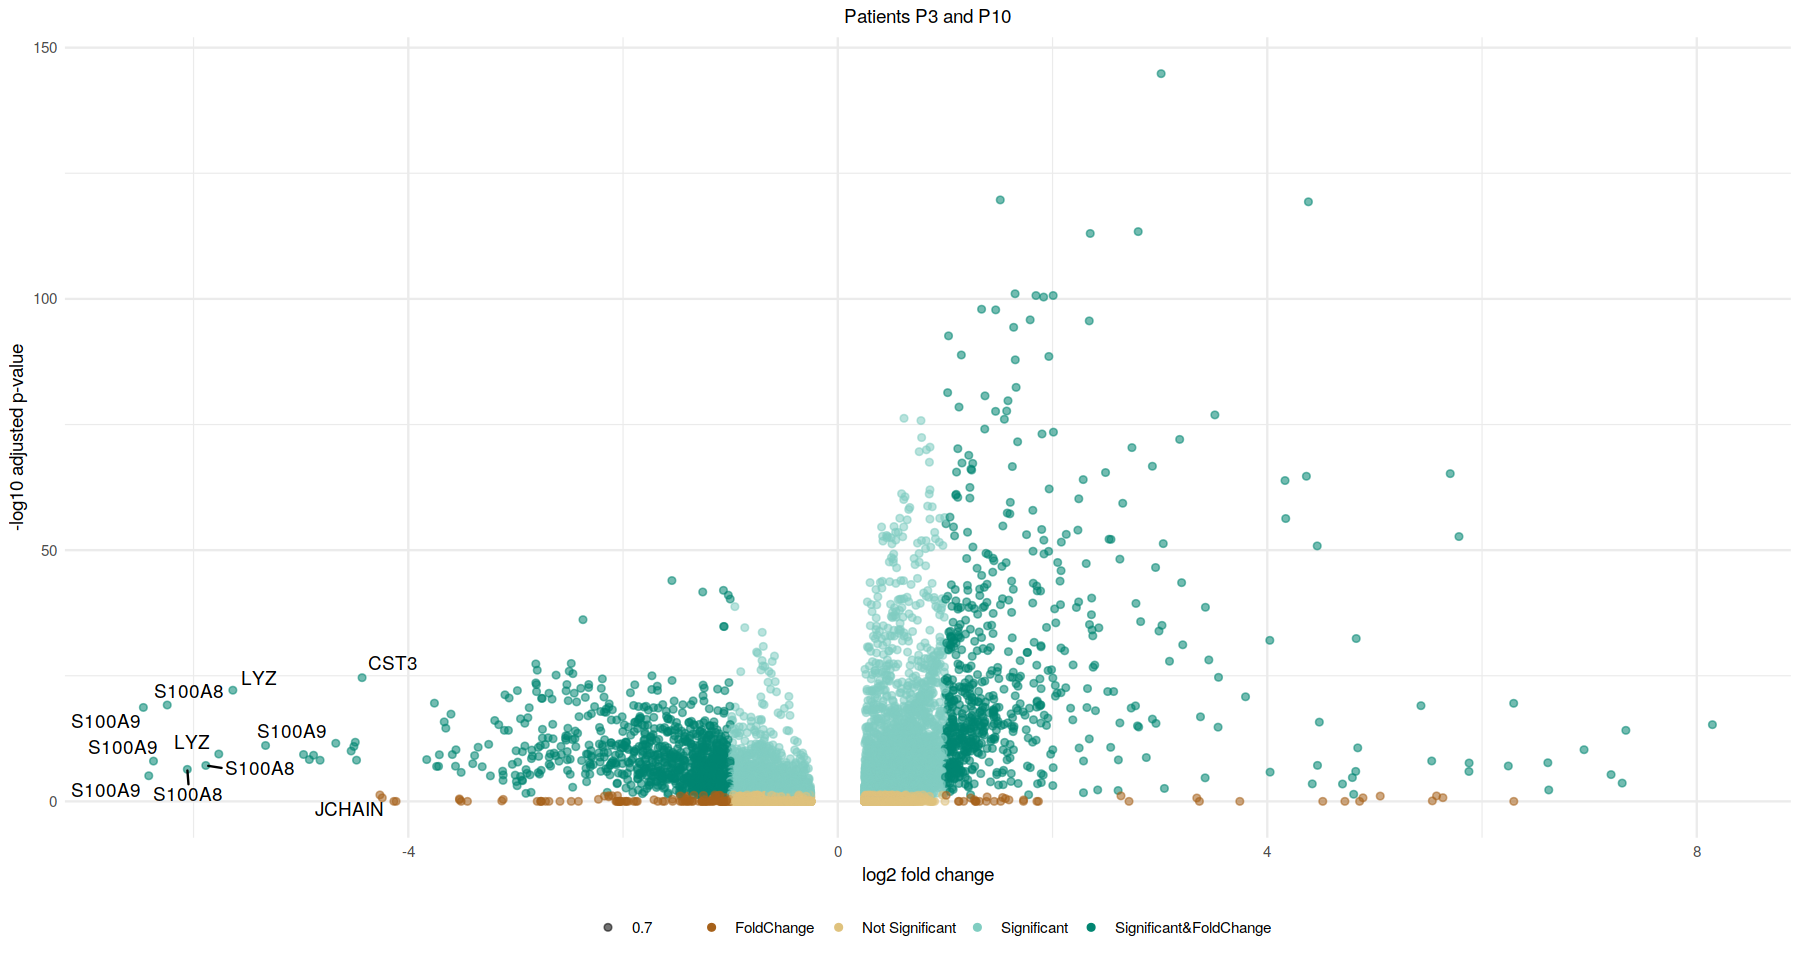

In [152]:
p3_p10_plot <- ggplot(covid_p3_p10_markers) +
  geom_point(aes(x = avg_log2FC, y = -log10(p_val_adj), colour = group, alpha=0.7)) +
  geom_text_repel(data=top_peaks[1:20,],aes(x = avg_log2FC, y = -log10(p_val_adj),label=gene))+
  scale_color_brewer(palette = "BrBG")+
  ggtitle("Patients P3 and P10")+
  xlab("log2 fold change") + 
  ylab("-log10 adjusted p-value") +
  theme_minimal()+
  theme(legend.position = "bottom",
        legend.title = element_blank(),
        plot.title = element_text(size = rel(1), hjust = 0.5),
        axis.title = element_text(size = rel(1))) 

options(repr.plot.width=15, repr.plot.height=8)
p3_p10_plot

In [153]:
P3_P10_splitted <- SplitObject(covid_p3_p10, split.by = "patient")
head(P3_P10_splitted$P3[[]])
head(P3_P10_splitted$P10[[]])

,orig.ident,nCount_RNA,nFeature_RNA,patient,perc_mitochondrial,RNA_snn_res.1,seurat_clusters
,<fct>,<dbl>,<int>,<chr>,<dbl>,<fct>,<fct>
P3-AAAGATGGTATCAGTC,COVID-19,6605,2118,P3,4.799394,0,0
P3-AAAGATGTCGCTTGTC,COVID-19,8523,2391,P3,4.376393,1,1
P3-AAATGCCTCACAACGT,COVID-19,10841,3029,P3,4.750484,1,1
P3-AACACGTGTTTGACTG,COVID-19,10012,2772,P3,3.865362,1,1
P3-AACACGTTCGTGGGAA,COVID-19,7600,2258,P3,3.539474,0,0
P3-AACACGTTCTTGCCGT,COVID-19,21327,3385,P3,2.977446,6,6


,orig.ident,nCount_RNA,nFeature_RNA,patient,perc_mitochondrial,RNA_snn_res.1,seurat_clusters
,<fct>,<dbl>,<int>,<chr>,<dbl>,<fct>,<fct>
P10-AAAGCAAAGTACGTTC,COVID-19,15873,3340,P10,4.680905,9,9
P10-AAAGTAGGTGTTGAGG,COVID-19,7441,2344,P10,3.803252,7,7
P10-AACCATGAGATCTGAA,COVID-19,6647,2077,P10,3.715962,7,7
P10-AACTCAGGTGTATGGG,COVID-19,7420,2275,P10,4.878706,7,7
P10-AACTCAGTCAACACGT,COVID-19,8454,2509,P10,4.826118,5,5
P10-AACTCCCTCTTAGAGC,COVID-19,9297,2686,P10,4.022803,7,7


In [154]:
# test.use = differentially expressed genes between two groups of cells using the Student's t-test.
# min.pct = only test genes detected in a minimum fraction of min.pct cells in either of the two populations.
p3_markers <- FindAllMarkers(object = P3_P10_splitted$P3, min.pct = 0.1, test.use="t")
p3_markers %>% group_by(cluster)
head(p3_markers, n=20L)

Calculating cluster 0

Calculating cluster 1

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 8

Calculating cluster 9



p_val,avg_log2FC,pct.1,pct.2,p_val_adj,cluster,gene
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
8.791676e-70,1.4654083,1.000,0.511,1.509443e-65,0,FCN1
2.600004e-67,-2.6966178,0.027,0.677,4.463947e-63,0,PTPRCAP
8.447786e-67,1.6990507,1.000,0.598,1.450400e-62,0,S100A9
1.689515e-65,1.7167230,1.000,0.577,2.900728e-61,0,S100A8
7.160046e-64,1.4332599,0.995,0.483,1.229308e-59,0,RETN
1.089096e-62,1.4557907,1.000,0.577,1.869869e-58,0,LYZ
1.637324e-61,1.3564015,0.995,0.541,2.811122e-57,0,MNDA
4.421070e-61,1.1697650,1.000,0.734,7.590534e-57,0,GRN
3.433324e-60,1.2559461,1.000,0.550,5.894675e-56,0,TYROBP


,p_val,avg_log2FC,pct.1,pct.2,p_val_adj,cluster,gene
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
FCN1,8.791676e-70,1.4654083,1.000,0.511,1.509443e-65,0,FCN1
PTPRCAP,2.600004e-67,-2.6966178,0.027,0.677,4.463947e-63,0,PTPRCAP
S100A9,8.447786e-67,1.6990507,1.000,0.598,1.450400e-62,0,S100A9
S100A8,1.689515e-65,1.7167230,1.000,0.577,2.900728e-61,0,S100A8
RETN,7.160046e-64,1.4332599,0.995,0.483,1.229308e-59,0,RETN
LYZ,1.089096e-62,1.4557907,1.000,0.577,1.869869e-58,0,LYZ
MNDA,1.637324e-61,1.3564015,0.995,0.541,2.811122e-57,0,MNDA
GRN,4.421070e-61,1.1697650,1.000,0.734,7.590534e-57,0,GRN
TYROBP,3.433324e-60,1.2559461,1.000,0.550,5.894675e-56,0,TYROBP


In [155]:
# test.use = differentially expressed genes between two groups of cells using the Student's t-test.
# min.pct = only test genes detected in a minimum fraction of min.pct cells in either of the two populations.
p10_markers <- FindAllMarkers(object = P3_P10_splitted$P10, min.pct = 0.1, test.use = "t")
p10_markers %>% group_by(cluster)
head(p10_markers, n=20L)

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8

Calculating cluster 9



p_val,avg_log2FC,pct.1,pct.2,p_val_adj,cluster,gene
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
9.455515e-57,-1.7199614,0,0.756,1.623417e-52,0,SSR3
1.183941e-54,-1.4290636,0,0.747,2.032708e-50,0,CKLF
3.399736e-51,-1.8219530,0,0.738,5.837006e-47,0,SEPT6
1.027327e-49,-1.3972990,0,0.707,1.763817e-45,0,PSMA6
4.521654e-42,-1.1190208,0,0.622,7.763227e-38,0,HSPE1
6.817311e-41,-1.1365417,0,0.627,1.170464e-36,0,LSM8
9.900856e-41,-1.0923202,0,0.618,1.699878e-36,0,NDUFB5
3.034845e-40,-1.1382072,0,0.618,5.210525e-36,0,CCT4
3.185731e-40,-1.0686675,0,0.604,5.469582e-36,0,ZRANB2


,p_val,avg_log2FC,pct.1,pct.2,p_val_adj,cluster,gene
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
SSR3,9.455515e-57,-1.7199614,0,0.756,1.623417e-52,0,SSR3
CKLF,1.183941e-54,-1.4290636,0,0.747,2.032708e-50,0,CKLF
SEPT6,3.399736e-51,-1.8219530,0,0.738,5.837006e-47,0,SEPT6
PSMA6,1.027327e-49,-1.3972990,0,0.707,1.763817e-45,0,PSMA6
HSPE1,4.521654e-42,-1.1190208,0,0.622,7.763227e-38,0,HSPE1
LSM8,6.817311e-41,-1.1365417,0,0.627,1.170464e-36,0,LSM8
NDUFB5,9.900856e-41,-1.0923202,0,0.618,1.699878e-36,0,NDUFB5
CCT4,3.034845e-40,-1.1382072,0,0.618,5.210525e-36,0,CCT4
ZRANB2,3.185731e-40,-1.0686675,0,0.604,5.469582e-36,0,ZRANB2


In [156]:
# Preliminarly grouping all genes as "Not Significant"
p3_markers["group"] <- "Not Significant"
# Change the grouping for the entries with significance but not a large enough Fold change
p3_markers[which(
    p3_markers['p_val_adj'] < 0.05 & 
    abs(p3_markers['avg_log2FC']) < 1 ),"group"] <- "Significant"
# Change the grouping for the entries a large enough Fold change but not a low enough p value
p3_markers[which(
    p3_markers['p_val_adj'] > 0.05 & 
    abs(p3_markers['avg_log2FC']) > 1 ),"group"] <- "FoldChange"
# Change the grouping for the entries with both significance and large enough fold change
p3_markers[which(
    p3_markers['p_val_adj'] < 0.05 & 
    abs(p3_markers['avg_log2FC']) > 1 ),"group"] <- "Significant&FoldChange"
# Find and label the top peaks
top_peaks_p3 <- p3_markers[with(p3_markers, order(avg_log2FC, p_val_adj)),][1:20,]
top_peaks_p3 <- rbind(
    top_peaks, 
    p3_markers[with(p3_markers, order(-avg_log2FC, p_val_adj)),][1:20,])

head(top_peaks_p3, n = 20L)

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj,cluster,gene,group
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>,<chr>
S100A9.2,1.182860e-23,-6.467402,0.171,0.748,2.030852e-19,3,S100A9,Significant&FoldChange
S100A9.6,4.687660e-10,-6.417225,0.375,0.707,8.048243e-06,8,S100A9,Significant&FoldChange
S100A9.7,5.627031e-13,-6.373143,0.081,0.721,9.661049e-09,9,S100A9,Significant&FoldChange
S100A8.2,3.876790e-24,-6.245208,0.145,0.748,6.656060e-20,3,S100A8,Significant&FoldChange
S100A8.5,2.499154e-11,-6.058026,0.250,0.711,4.290797e-07,8,S100A8,Significant&FoldChange
S100A8.6,4.186165e-12,-5.885825,0.135,0.715,7.187227e-08,9,S100A8,Significant&FoldChange
LYZ.6,2.214040e-14,-5.765079,0.100,0.741,3.801285e-10,8,LYZ,Significant&FoldChange
LYZ.3,4.378280e-27,-5.634069,0.105,0.775,7.517070e-23,3,LYZ,Significant&FoldChange
S100A9.4,4.431143e-16,-5.329397,0.204,0.727,7.607829e-12,6,S100A9,Significant&FoldChange


In [157]:
# Preliminarly grouping all genes as "Not Significant"
p10_markers["group"] <- "Not Significant"
# Change the grouping for the entries with significance but not a large enough Fold change
p10_markers[which(
    p10_markers['p_val_adj'] < 0.05 & 
    abs(p10_markers['avg_log2FC']) < 1 ),"group"] <- "Significant"
# Change the grouping for the entries a large enough Fold change but not a low enough p value
p10_markers[which(
    p10_markers['p_val_adj'] > 0.05 & 
    abs(p10_markers['avg_log2FC']) > 1 ),"group"] <- "FoldChange"
# Change the grouping for the entries with both significance and large enough fold change
p10_markers[which(
    p10_markers['p_val_adj'] < 0.05 & 
    abs(p10_markers['avg_log2FC']) > 1 ),"group"] <- "Significant&FoldChange"
# Find and label the top peaks
top_peaks_p10 <- p10_markers[with(p10_markers, order(avg_log2FC, p_val_adj)),][1:20,]
top_peaks_p10 <- rbind(
    top_peaks, 
    p10_markers[with(p10_markers, order(-avg_log2FC, p_val_adj)),][1:20,])

head(top_peaks_p10, n = 20L)

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj,cluster,gene,group
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>,<chr>
S100A9.2,1.182860e-23,-6.467402,0.171,0.748,2.030852e-19,3,S100A9,Significant&FoldChange
S100A9.6,4.687660e-10,-6.417225,0.375,0.707,8.048243e-06,8,S100A9,Significant&FoldChange
S100A9.7,5.627031e-13,-6.373143,0.081,0.721,9.661049e-09,9,S100A9,Significant&FoldChange
S100A8.2,3.876790e-24,-6.245208,0.145,0.748,6.656060e-20,3,S100A8,Significant&FoldChange
S100A8.5,2.499154e-11,-6.058026,0.250,0.711,4.290797e-07,8,S100A8,Significant&FoldChange
S100A8.6,4.186165e-12,-5.885825,0.135,0.715,7.187227e-08,9,S100A8,Significant&FoldChange
LYZ.6,2.214040e-14,-5.765079,0.100,0.741,3.801285e-10,8,LYZ,Significant&FoldChange
LYZ.3,4.378280e-27,-5.634069,0.105,0.775,7.517070e-23,3,LYZ,Significant&FoldChange
S100A9.4,4.431143e-16,-5.329397,0.204,0.727,7.607829e-12,6,S100A9,Significant&FoldChange


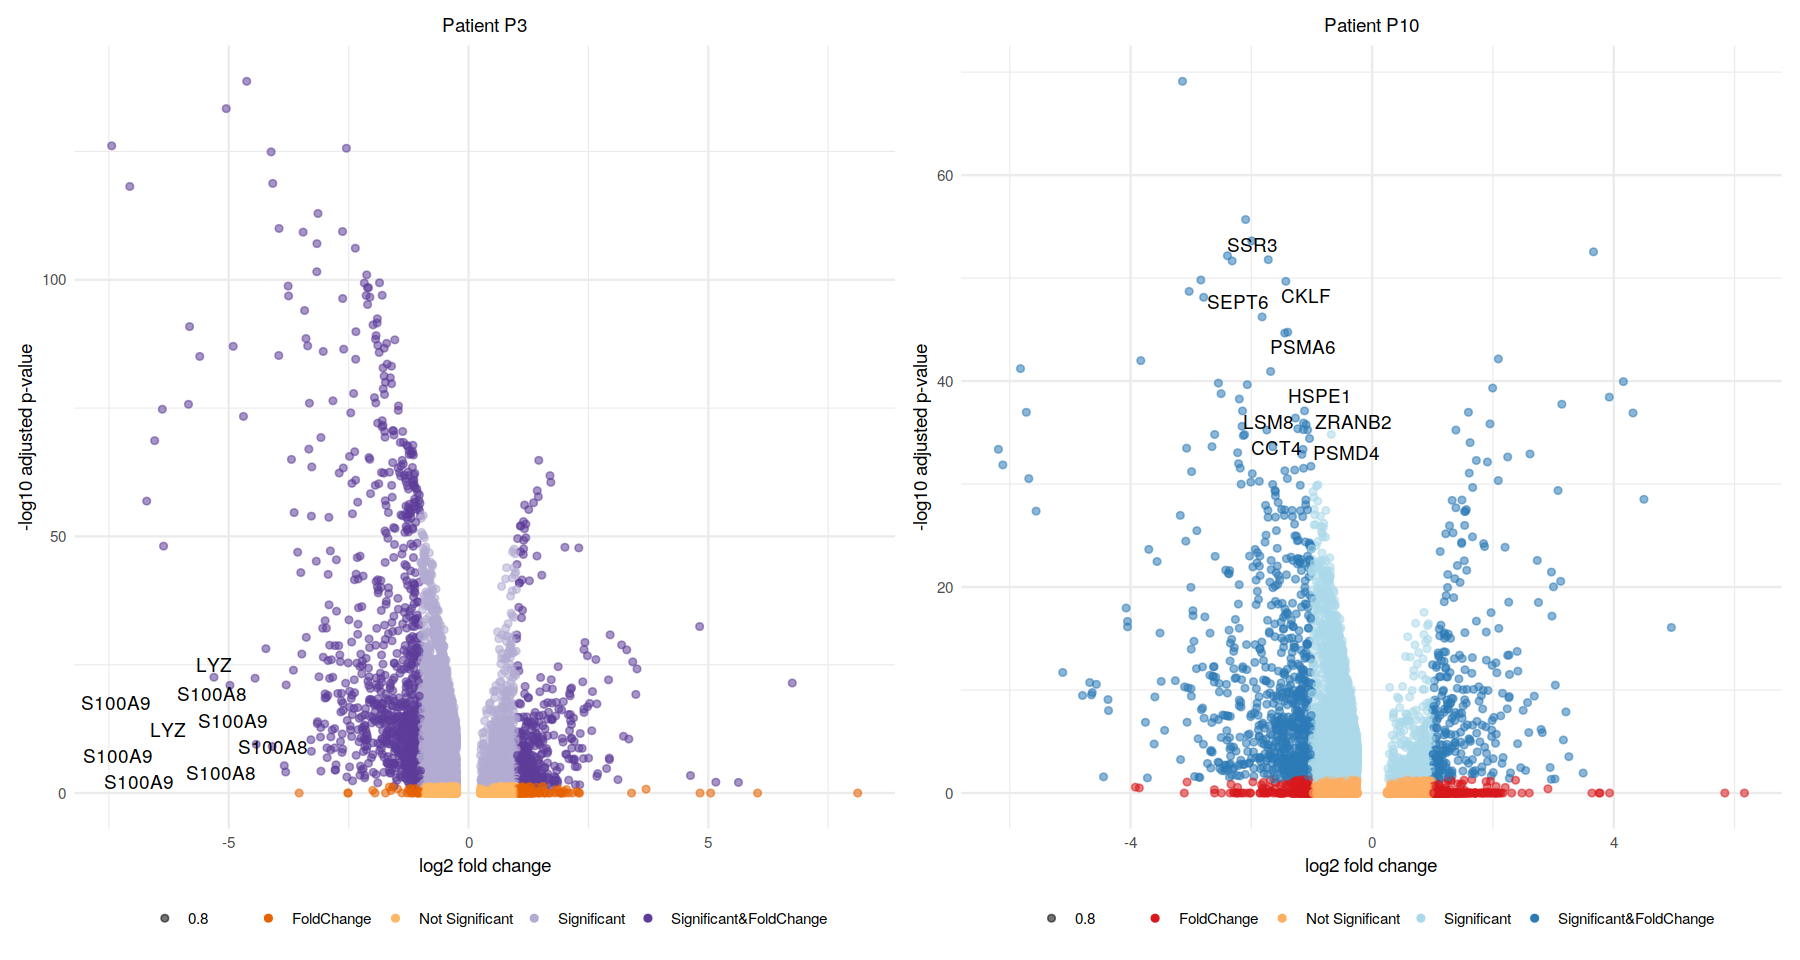

In [158]:
p3_plot <- ggplot(p3_markers) +
  geom_point(aes(x = avg_log2FC, y = -log10(p_val_adj), colour = group, alpha=0.8)) +
  geom_text_repel(data=top_peaks_p3[1:10,],aes(x = avg_log2FC, y = -log10(p_val_adj),label=gene))+
  scale_color_brewer(palette = "PuOr")+
  ggtitle("Patient P3")+
  xlab("log2 fold change") + 
  ylab("-log10 adjusted p-value") +
  theme_minimal()+
  theme(legend.position = "bottom",
        legend.title = element_blank(),
        plot.title = element_text(size = rel(1), hjust = 0.5),
        axis.title = element_text(size = rel(1))) 

p10_plot <- ggplot(p10_markers) +
  geom_point(aes(x = avg_log2FC, y = -log10(p_val_adj), colour = group, alpha=0.8)) +
  geom_text_repel(data=p10_markers[1:10,],aes(x = avg_log2FC, y = -log10(p_val_adj),label=gene))+
  ggtitle("Patient P10")+
  scale_color_brewer(palette = "RdYlBu")+
  xlab("log2 fold change") + 
  ylab("-log10 adjusted p-value") +
  theme_minimal()+
  theme(legend.position = "bottom",
        legend.title = element_blank(),
        plot.title = element_text(size = rel(1), hjust = 0.5),
        axis.title = element_text(size = rel(1))) 

options(repr.plot.width=15, repr.plot.height=8)
p3_plot + p10_plot